In [1]:
import imp
import sys
sys.path.insert(0,"/home/ljw/Dropbox/dev/libpysal3")
import libpysal as lp
import geopandas as gpd
import numpy as np
from bounder import region
from bounder.region.abstracts import Constraint
from bounder.region.methods import AZP
from bounder.region import utils as rut
from bounder.region.functions.compact import boundary_amplitude, convex_hull_ratio
imp.reload(region)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
south = gpd.read_file('/home/ljw/Dropbox/dev/pysal/pysal/examples/south/south.shp').query('STATE_NAME == "Texas"')
south.index = np.arange(len(south))
W_start = lp.weights.Contiguity.Rook.from_dataframe(south)
south.crs = {'init':'epsg:4269'}
south = south.to_crs(epsg=5070)
W_fin = lp.weights.Contiguity.Rook.from_dataframe(south)
np.testing.assert_allclose(W_start.sparse.toarray(), W_fin.sparse.toarray())

In [3]:
from bounder.region.functions.abstracts import Constraint, Objective, MultiObjective

In [4]:
mo = MultiObjective.from_kw(geometry=boundary_amplitude, 
                            GI89 = lambda x: x.var(), weights=[1,40004])

In [5]:
mo.weights

[1, 40004]

In [6]:
AZP_ = region.methods.AZP(mo ,
                          constraints=Constraint(FH90 = lambda x: x.count()).above(30),
                          remember=True)
AZP_.add_data(south)

In [7]:
AZP_._log = lambda x: x

In [8]:
pts = pd.DataFrame(lp.weights.util.get_points_array(south.geometry))
pts.index = south.index
AZP_.initialize(5, data=pts, w=W_fin)

In [9]:
AZP_.score()

446.68253359734172

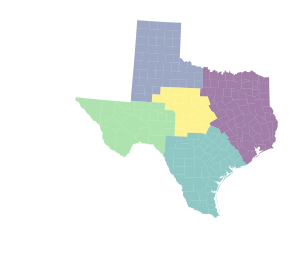

In [10]:
AZP_.plot()
plt.show()

(<matplotlib.figure.Figure at 0x7f11713eb400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f11713f60f0>)

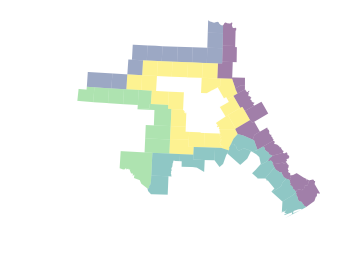

In [11]:
AZP_.plot_boundary()

In [12]:
AZP_._data.groupby('current_labels').count()

,BLK60,BLK70,BLK80,BLK90,CNTY_FIPS,COFIPS,DNL60,DNL70,DNL80,DNL90,...,STATE_FIPS,STATE_NAME,STFIPS,UE60,UE70,UE80,UE90,geometry,0,1
current_labels,,,,,,,,,,,,,,,,,,,,,
0,84,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,84
1,59,59,59,59,59,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,59
2,57,57,57,57,57,57,57,57,57,57,...,57,57,57,57,57,57,57,57,57,57
3,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
4,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29


In [13]:
AZP_.refine(rounds=10, progressbar = True)

100%|██████████| 50/50 [01:40<00:00,  2.49s/it]


In [ ]:
AZP_.slack()

array([[-58, -24, -20,   2,  -4]])

In [ ]:
AZP_.plot()

In [ ]:
AZP_.objective.weights

In [ ]:
AZP_.objective._function_cache[0](AZP_._data.groupby('current_labels'))*1, \
AZP_.objective._function_cache[1](AZP_._data.groupby('current_labels'))*40000

In [ ]:
AZP_.objective(AZP_._data.groupby('current_labels'))

In [ ]:
plt.plot(AZP_.objective._trace)